In [1]:
#Import Libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from main import get_loader
from transform import get_a_train_transform, get_a_test_transform
from utils import get_device
from utils import compute_mean_std

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
train_data = datasets.CIFAR10('./data', train=True, download=True)
test_data = datasets.CIFAR10('./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class_map = train_data.class_to_idx
class_map

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
use_cuda, use_mps, device = get_device()

In [8]:
# Train/Test Loader
train_data, test_data, train_loader, test_loader = get_loader(train_data, test_data, get_a_train_transform(), get_a_test_transform(), use_cuda=use_cuda, use_mps=use_mps)

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print('images in batch and shape of an image', images.shape)
print('labels : ', labels.shape)

images in batch and shape of an image torch.Size([512, 3, 32, 32])
labels :  torch.Size([512])


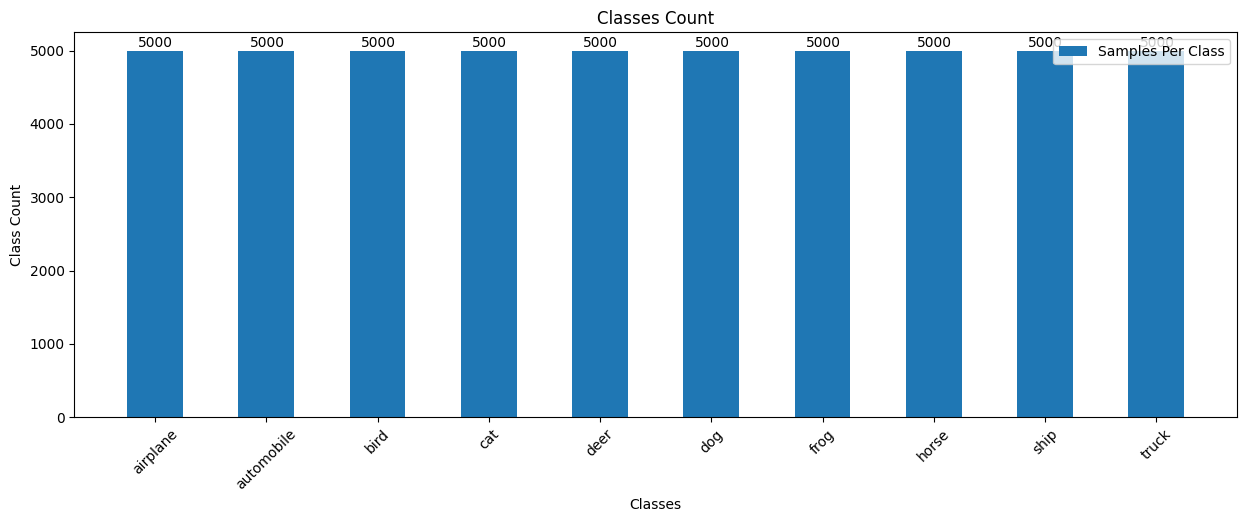

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

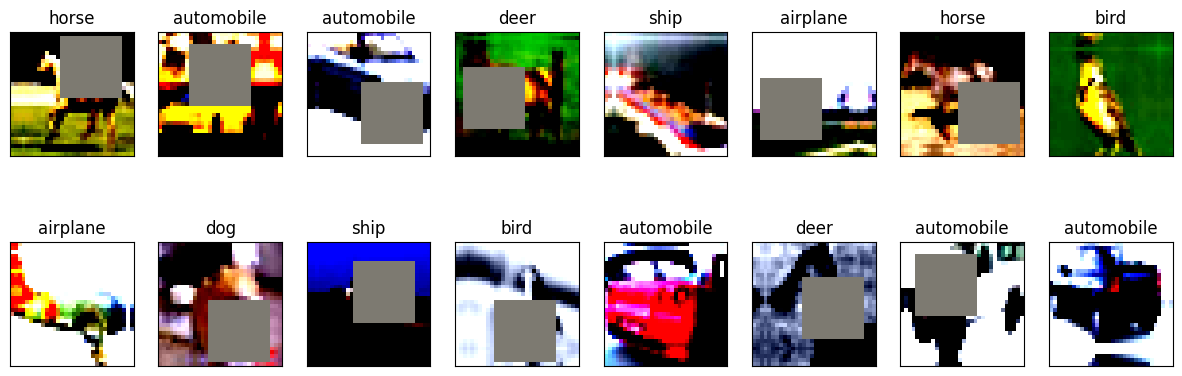

In [10]:
from visualise import print_class_scale, print_samples

torch.manual_seed(1)
show_dataset_analyze = True

if show_dataset_analyze:
    print_class_scale(train_loader, class_map)
    print_samples(train_loader, class_map, count=16)

In [11]:
from models.resnet import ResNet18
from utils import model_summary

show_summary = True

model = ResNet18(device).to(device)
if show_summary:
    model_summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

 70%|███████   | 141/200 [02:06<00:53,  1.11it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 4.93E-02


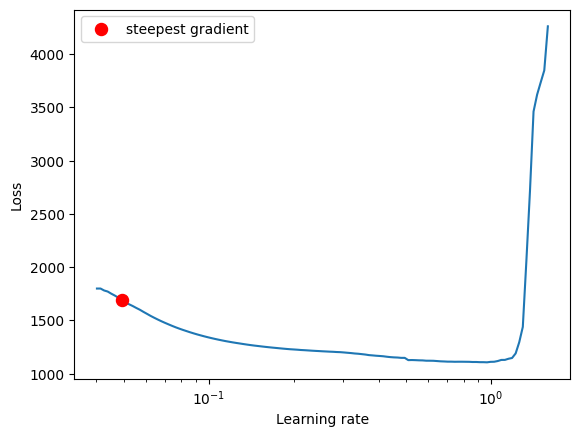

In [12]:
from torch_lr_finder import LRFinder
from main import set_optim

optimizer = set_optim(model, opt="Adam", learnin_rate=0.03, weight_decay_=1e-4)
criterion = nn.CrossEntropyLoss(reduction="sum")

lr_finder = LRFinder(model, optimizer, criterion, device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot()
lr_finder.reset() # Never forget running this brfore starting training.

In [13]:
from main import model_train
from main import model_test
from main import EPOCHS
from main import get_one_cycle_lr_scheduler
from utils import save_best

scheduler = get_one_cycle_lr_scheduler(optimizer, max_lr=4.51E-02, steps_per_epoch=len(train_loader))

best_score=0
for epoch in range(1, EPOCHS+1):
    print("Epoch ", epoch)
    model_train(model, device, train_loader, optimizer, criterion, scheduler)
    model_test(model, device, test_loader, criterion)

Epoch  1


Train: Loss=474.4518 Batch_id=97 Accuracy=39.47: 100%|██████████| 98/98 [01:35<00:00,  1.03it/s]



Test set: Average loss: 1.6636, Accuracy: 4390/10000 (43.90%)

Epoch  2


Train: Loss=423.4795 Batch_id=97 Accuracy=52.60: 100%|██████████| 98/98 [01:35<00:00,  1.03it/s]



Test set: Average loss: 1.4570, Accuracy: 5259/10000 (52.59%)

Epoch  3


Train: Loss=307.1302 Batch_id=97 Accuracy=60.32: 100%|██████████| 98/98 [01:34<00:00,  1.03it/s]



Test set: Average loss: 1.2798, Accuracy: 5876/10000 (58.76%)

Epoch  4


Train: Loss=298.6168 Batch_id=97 Accuracy=64.73: 100%|██████████| 98/98 [01:34<00:00,  1.04it/s]



Test set: Average loss: 1.2471, Accuracy: 6136/10000 (61.36%)

Epoch  5


Train: Loss=249.9032 Batch_id=97 Accuracy=69.71: 100%|██████████| 98/98 [01:35<00:00,  1.03it/s]



Test set: Average loss: 1.7878, Accuracy: 5619/10000 (56.19%)

Epoch  6


Train: Loss=223.8867 Batch_id=97 Accuracy=73.51: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]



Test set: Average loss: 0.8854, Accuracy: 7359/10000 (73.59%)

Epoch  7


Train: Loss=248.5606 Batch_id=97 Accuracy=76.81: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]



Test set: Average loss: 0.6295, Accuracy: 7887/10000 (78.87%)

Epoch  8


Train: Loss=201.9273 Batch_id=97 Accuracy=78.65: 100%|██████████| 98/98 [01:35<00:00,  1.03it/s]



Test set: Average loss: 0.7616, Accuracy: 7624/10000 (76.24%)

Epoch  9


Train: Loss=167.5269 Batch_id=97 Accuracy=80.56: 100%|██████████| 98/98 [01:35<00:00,  1.03it/s]



Test set: Average loss: 0.5045, Accuracy: 8308/10000 (83.08%)

Epoch  10


Train: Loss=167.6587 Batch_id=97 Accuracy=82.33: 100%|██████████| 98/98 [01:35<00:00,  1.03it/s]



Test set: Average loss: 0.4440, Accuracy: 8457/10000 (84.57%)

Epoch  11


Train: Loss=162.1870 Batch_id=97 Accuracy=83.64: 100%|██████████| 98/98 [01:35<00:00,  1.03it/s]



Test set: Average loss: 0.4305, Accuracy: 8536/10000 (85.36%)

Epoch  12


Train: Loss=125.0681 Batch_id=97 Accuracy=84.67: 100%|██████████| 98/98 [01:36<00:00,  1.02it/s]



Test set: Average loss: 0.5562, Accuracy: 8189/10000 (81.89%)

Epoch  13


Train: Loss=101.1941 Batch_id=97 Accuracy=86.08: 100%|██████████| 98/98 [01:35<00:00,  1.03it/s]



Test set: Average loss: 0.3449, Accuracy: 8830/10000 (88.30%)

Epoch  14


Train: Loss=129.2303 Batch_id=97 Accuracy=86.81: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]



Test set: Average loss: 0.3728, Accuracy: 8753/10000 (87.53%)

Epoch  15


Train: Loss=114.7682 Batch_id=97 Accuracy=87.71: 100%|██████████| 98/98 [01:34<00:00,  1.04it/s]



Test set: Average loss: 0.3406, Accuracy: 8867/10000 (88.67%)

Epoch  16


Train: Loss=140.2298 Batch_id=97 Accuracy=88.72: 100%|██████████| 98/98 [01:35<00:00,  1.03it/s]



Test set: Average loss: 0.3369, Accuracy: 8864/10000 (88.64%)

Epoch  17


Train: Loss=102.0509 Batch_id=97 Accuracy=89.92: 100%|██████████| 98/98 [01:36<00:00,  1.02it/s]



Test set: Average loss: 0.2968, Accuracy: 9018/10000 (90.18%)

Epoch  18


Train: Loss=91.7150 Batch_id=97 Accuracy=90.81: 100%|██████████| 98/98 [01:34<00:00,  1.03it/s] 



Test set: Average loss: 0.2744, Accuracy: 9118/10000 (91.18%)

Epoch  19


Train: Loss=103.1521 Batch_id=97 Accuracy=91.77: 100%|██████████| 98/98 [01:34<00:00,  1.04it/s]



Test set: Average loss: 0.2492, Accuracy: 9200/10000 (92.00%)

Epoch  20


Train: Loss=71.3389 Batch_id=97 Accuracy=92.17: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it] 



Test set: Average loss: 0.2379, Accuracy: 9223/10000 (92.23%)



In [16]:
path = "trained_model/cifar10.pth"
torch.save(model.state_dict(), path)

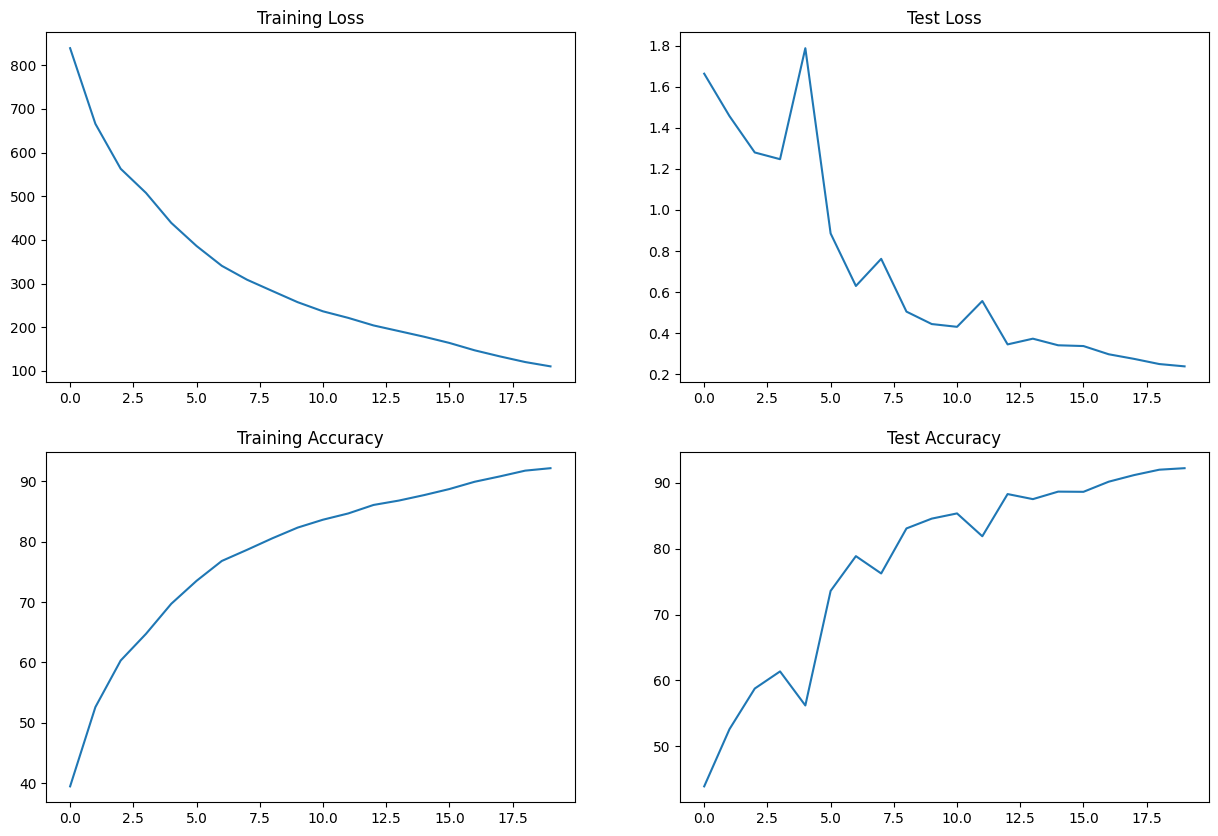

In [17]:
from visualise import draw_graphs
draw_graphs()

# Incorrect Predictions

In [12]:
from utils import get_incorrrect_predictions, load_weights_from_path

model = load_weights_from_path(model, "trained_model/cifar10.pth")

incorrect = get_incorrrect_predictions(model, test_loader, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Incorrect Predictions 777


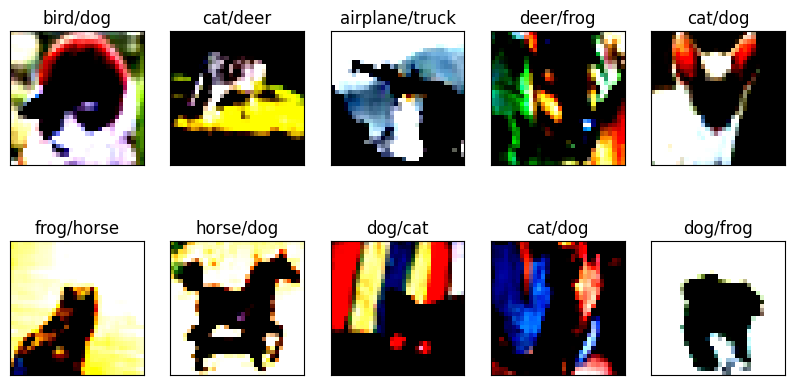

In [13]:
from visualise import plot_incorrect_predictions

labels_mapping = {idx:cls for cls, idx in class_map.items()}
plot_incorrect_predictions(incorrect, labels_mapping, 10)

# GradCAM

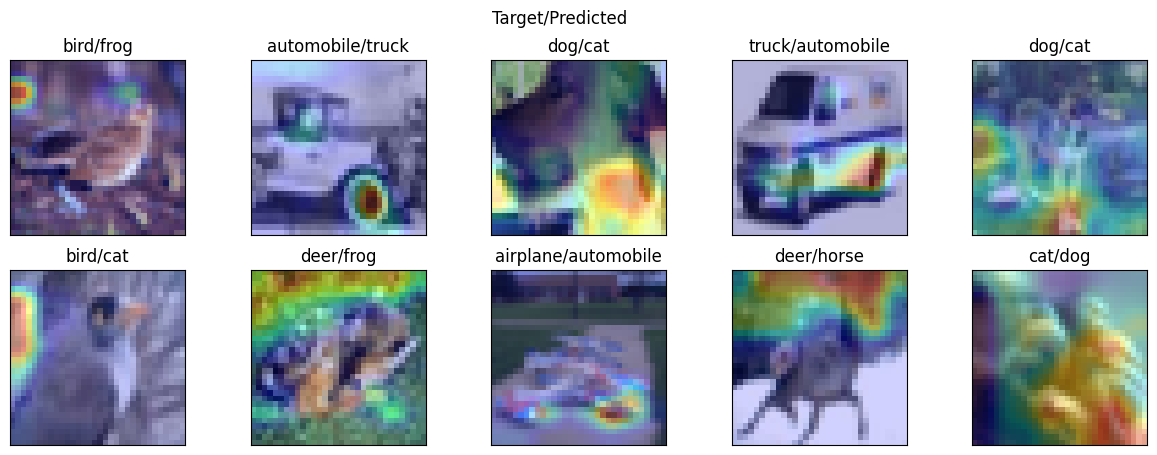

In [189]:
from models.resnet import ResNet18
from utils import load_weights_from_path
from visualise import plot_incorrect_pred_GradCAM

model = ResNet18(device).to(device)
model = load_weights_from_path(model, "trained_model/cifar10.pth")
labels_mapping = {idx:cls for cls, idx in class_map.items()}

target_layers = [model.layer3[-1]]
plot_incorrect_pred_GradCAM(model, target_layers=target_layers, dataset_std=(0.2023, 0.1994, 0.2010), dataset_mean=(0.4914, 0.4822, 0.4465),
                            incorrect_predictions=incorrect, labels_mapping=labels_mapping, use_cuda=use_cuda)

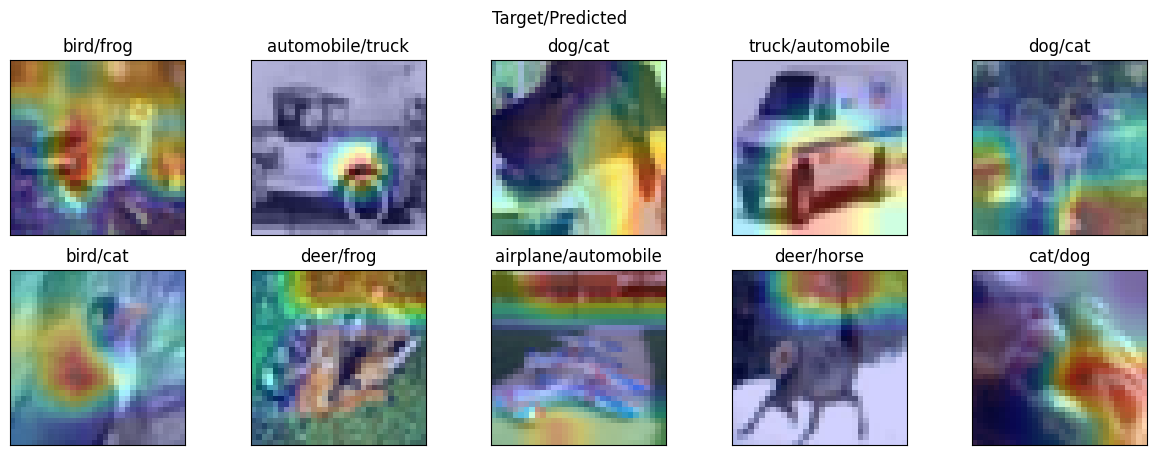

In [190]:
target_layers = [model.layer4[-1]]
plot_incorrect_pred_GradCAM(model, target_layers=target_layers, dataset_std=(0.2023, 0.1994, 0.2010), dataset_mean=(0.4914, 0.4822, 0.4465),
                            incorrect_predictions=incorrect, labels_mapping=labels_mapping, use_cuda=use_cuda)